### Properties of inorganic chemical precursors

This Jupyter notebook cleans data imported from the CRC Handbook of Chemistry and Physics, 85th edition related to the solubility of various compounds. It then attempts to learn general rules about chemical solubility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colNames = ['no', 'name', 'chemical_formula', 'CAS_no', 'mol_weight', 'physical_form', 'melting_point', 'boiling point', 
            'density', 'solubility_per_100gH2O', 'qualitative_solubility', 'blanks']
df = pd.read_csv('tabula-Inorganic_solubility_with_lines.tsv', sep='\t', names=colNames)
df = df.drop(labels='blanks', axis=1)
print(df.shape)

(2740, 11)


In [3]:
# Eliminate blank lines
df = df.dropna(axis=0, thresh=1)
df.shape

(2711, 11)

In [4]:
# Get rid of the header line that sometimes accompanies a new page
df = df[df.no != 'No.'] 
print(df.shape)
print(df.iloc[:,:2].tail(5))

(2681, 11)
        no                           name
2735  2677              Zirconium nitride
2736  2678            Zirconium phosphide
2737  2679             Zirconium silicide
2738  2680              Zirconyl chloride
2739  2681  Zirconyl chloride octahydrate


More cleaning required - some of the reference footnotes in the solubility column have been read in as actual numbers! Let's make a function that tries to eliminate 2 significant digits from the end of the number and see whether the result is zero. If it is, we'll assume that the number had no footnote; if it's not, we'll just use that number.

In [5]:
def clean_solubility_references(sol_str):
    ''' Clean reference superscript numbers from solubility values
    Attempts to clean the solubility string sol_str by removing the last two characters, 
    comparing the resulting number to zero.
        
    sol_str - string to be cleaned
    returns float
    '''
    if(len(str(sol_str)) < 3): return float(sol_str) # Don't try to convert an empty string to a float
    stripped_number = float(str(sol_str)[:-2]) 
    if stripped_number != 0: return stripped_number
    return float(sol_str)
        
df.solubility_per_100gH2O = df.solubility_per_100gH2O.apply(lambda x: clean_solubility_references(x) if(pd.notnull(x)) else x)

In [6]:
print(df[['name', 'solubility_per_100gH2O']][df.solubility_per_100gH2O.notnull()].head(10))
print(df.shape)
print(df[['solubility_per_100gH2O', 'name']].sort_values(by='solubility_per_100gH2O', ascending=False).head(5))
df.solubility_per_100gH2O.describe()

                                name  solubility_per_100gH2O
20                 Aluminum chloride                    45.1
21     Aluminum chloride hexahydrate                    45.1
24                 Aluminum fluoride                     0.5
25     Aluminum fluoride monohydrate                     0.5
26      Aluminum fluoride trihydrate                     0.5
35                  Aluminum nitrate                    68.9
36      Aluminum nitrate nonahydrate                    68.9
44  Aluminum perchlorate nonahydrate                   182.0
51                  Aluminum sulfate                    38.5
52  Aluminum sulfate octadecahydrate                    38.5
(2681, 11)
      solubility_per_100gH2O                                     name
1065                  1308.0                       Indium(III) iodide
181                    987.0                   Antimony(III) chloride
1671                   709.0  Diphosphoric acid (pyrophosphoric acid)
590                    573.0          

count     735.000000
mean       72.683508
std       111.089021
min         0.000001
25%         1.085000
50%        37.000000
75%       101.000000
max      1308.000000
Name: solubility_per_100gH2O, dtype: float64

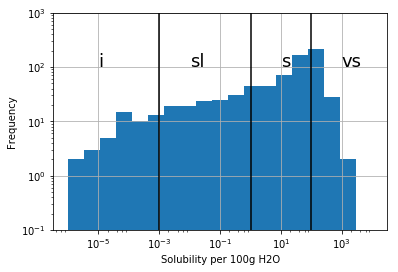

In [18]:
log_bins = np.logspace(-6, 4, num=20)
df.solubility_per_100gH2O.hist(bins=log_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Solubility per 100g H2O')
plt.ylabel('Frequency')
plt.vlines([1e-3, 1, 100], 1e-1, 1e3)
plt.ylim([1e-1, 1e3])
plt.text(1e-5, 1e2, 'i', fontsize=18)
plt.text(1e-2, 1e2, 'sl', fontsize=18)
plt.text(1e1, 1e2, 's', fontsize=18)
plt.text(1e3, 1e2, 'vs', fontsize=18)
plt.show()

Qualitative solubility limits:
* vs - very soluble - > 100g per 100g H2O
* s - soluble - 1-100g per 100g H2O
* sl - slightly soluble - 1e-3g - 1g per 100g H2O
* i - insoluble - less than 1e-3g per 100g H2O

Let's parse the qualitative solubility next. Where solubility is indicated, there is a marker (e.g. s for soluble, i for insoluble) followed by a list of solvents, then a semi-colon separator for listing other qualitative solubilities.

In [8]:
def parse_qualsol(qs_str):
    '''Parse a qualitative solubility string
    '''
    sols = dict()
    for solubility in qs_str.split(';'): # First parse each solubility classifier
        items = solubility.strip().split(' ')
        qs = items[0]
        for solvent in items[1:]: # Then add each solvent
            solvent = solvent.strip(', ')
            sols[solvent] = qs
    return sols
            
qsseries = df.qualitative_solubility[df.qualitative_solubility.notnull()].apply(parse_qualsol)
td = dict()
for entry in qsseries:
    for key, value in entry.items():
        td.setdefault(key, []).append(value)
td.keys()

dict_keys(['H2O', 'acid', 'alk', 'EtOH', 'dil', 'HCl', 'bz', 'tol', 'CS2', 'ctc', 'chl', 'eth', 'xyl', 'ace', 'pyr', 'os', 'peth', 'MeOH', 'py', 'et', 'ct', 'conc', 'hc', 'bz.', 'HNO3', 'diox', 'hot', 'iodide', 'soln', '(exp)', 'NH4OH', 'cold', 'H', '2O', 'thf', 'aqua', 'regia', 'KCN', '2SO4', 'HOAc', 'CN', 'HF', 'NaOH', 'acids', 'KCNS', 'warm', 'NH', '4OH', 'CC4l', 'DMF', 'DMSO', 'sl', 'EtOh', 'reac', 'H2SO4', 'of', 'SO2', 'in', 'HF-HNO3', 'mixture', 'HNO3/HF', 'EtAc'])

Let's find the qualitative solubilities with the most entries to see whether we have enough data points to do anything useful.

In [9]:
nEntries = []
for key, value in td.items():
    nEntries.append((len(value), key))
sorted(nEntries, reverse=True)[:5]

[(1257, 'H2O'), (715, 'EtOH'), (367, 'acid'), (170, 'eth'), (132, 'dil')]

For now, let's only look at water solubility and leave other solubility to further analysis.